<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Importing Libraries

In [1]:
import datetime
import time
import numpy as np
import math
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from typing import Tuple

In [2]:
os.getcwd()

'/Users/joel.pinho/Joel/External/NPR Dataset/metrecs/examples'

In [3]:
sys.path.insert(1, '../src/')

from metrecs.utils import (
    harmonic_number,
    normalized_scaled_harmonic_number_series,
    compute_normalized_distribution_multiple_categories,
    opt_merge_max_mappings,
    avoid_distribution_misspecification,
    user_level_RADio_multicategorical
)

# Inputing Data

In [4]:
# os.chdir('./examples/')
os.getcwd()

'/Users/joel.pinho/Joel/External/NPR Dataset/metrecs/examples'

In [5]:
top_at = 10

In [6]:
DATASET, SUFFIX = 'Globo', 'medium'
# DATASET, SUFFIX = 'MIND', 'small'

with open("paths.json") as f:
    paths = json.load(f)

PATH_BEHAVIOURS = paths[DATASET]["behaviours"]
PATH_ARTICLES = paths[DATASET]["articles"]
PATH_PREDICTIONS = paths[DATASET]["predictions"]

if DATASET == 'Globo':
    from utils import globo as dataset
    
    articles_df = dataset.read_articles(path=PATH_ARTICLES)
    behaviors_presel_df = dataset.read_behavior(path=PATH_BEHAVIOURS)

    pred_preselection_df = pd.DataFrame()
    for algo, algo_path_predictions in PATH_PREDICTIONS.items():
        _, temp_df = dataset.read_predictions(
            algo_path_predictions, behaviors_presel_df, top_k=10, algo=algo
        )
        pred_preselection_df = pd.concat([pred_preselection_df, temp_df])

elif DATASET == 'MIND':
    from utils import mind as dataset
    
    articles_df = dataset.read_articles(path=PATH_ARTICLES)
    behaviors_presel_df = dataset.read_behavior(path=PATH_BEHAVIOURS)

results_path = f'examples/results/{DATASET}'


In [7]:
articles_df.shape

(65298, 10)

In [8]:
behaviors_presel_df.shape

(92700, 20)

In [9]:
print(PATH_PREDICTIONS)

{'als': 'Globo/raw/npr_recommendations_als_v2.parquet', 'recents': 'Globo/raw/npr_recommendations_recents_v2.parquet', 'top': 'Globo/raw/npr_recommendations_top_v2.parquet'}


# Basic Functions to Compute Metrics

In [10]:
def get_classic_calibration(
    pred_preselection_df: pd.DataFrame,
    articles_df: pd.DataFrame,
    behaviors_presel_df: pd.DataFrame,
    cat_column: str,
    top_at: int,
) -> pd.DataFrame:
    df_cat = dataset.get_cat(
        pred_preselection_df,
        articles_df,
        "pred_slice_id",
        cat_column,
        top_at,
        slice_col=True,
    )

    df_cat_history = dataset.get_cat(
        behaviors_presel_df[["index", "user", "behavior_array"]],
        articles_df,
        "behavior_array",
        cat_column,
        top_at,
        slice_col=False,
    )
    df_cat_history = df_cat_history.rename(
        columns={
            "sorted_cat_list": "history_cat_list",
            "sorted_newsid_list": "history_newsid_list",
        }
    )

    df_calibration = df_cat.merge(df_cat_history, on=["index", "user"], how="inner")
    df_calibration["calibration"] = df_calibration.apply(
        lambda row: user_level_RADio_multicategorical(
            row["sorted_cat_list"],
            row["history_cat_list"],
            list(normalized_scaled_harmonic_number_series(len(row["sorted_cat_list"]))),
        ),
        axis=1,
    )
    return df_calibration

In [11]:
def get_classic_representation(
    pred_preselection_df: pd.DataFrame,
    articles_df: pd.DataFrame,
    behaviors_presel_df: pd.DataFrame,
    cat_column: str,
    top_at: int,
) -> pd.DataFrame:
    df_cat = dataset.get_cat(
        pred_preselection_df,
        articles_df,
        "pred_slice_id",
        cat_column,
        top_at,
        slice_col=True,
    )

    df_cat_pool = dataset.get_cat(
        behaviors_presel_df[["index", "user", "pool_array"]],
        articles_df,
        "pool_array",
        cat_column,
        top_at,
        slice_col=False,
    )
    df_cat_pool = df_cat_pool.rename(
        columns={
            "sorted_cat_list": "pool_cat_list",
            "sorted_newsid_list": "pool_newsid_list",
        }
    )

    df_representation = df_cat.merge(df_cat_pool, on=["index", "user"], how="inner")

    df_representation["representation"] = df_representation.apply(
        lambda row: user_level_RADio_multicategorical(
            row["sorted_cat_list"],
            row["pool_cat_list"],
            list(normalized_scaled_harmonic_number_series(len(row["sorted_cat_list"]))),
        ),
        axis=1,
    )

    return df_representation


In [12]:
def get_classic_fragmentation(
    pred_preselection_df: pd.DataFrame,
    articles_df: pd.DataFrame,
    cat_column: str,
    top_at: int,
    sample_size: float = 0.05,
) -> pd.DataFrame:
    df_cat = dataset.get_cat(
        pred_preselection_df,
        articles_df,
        "pred_slice_id",
        cat_column,
        top_at,
        slice_col=True,
    )
    df_cat2 = df_cat.sample(frac=0.01).rename(
        columns={
            "index": "other_index",
            "user": "other_user",
            "sorted_cat_list": "rec_cat_list",
            "sorted_newsid_list": "rec_newsid",
            "algo": "other_algo",
        }
    )
    df_cat["key"] = 0
    df_cat2["key"] = 0

    df_cat_cat = df_cat.merge(df_cat2, on="key", how="outer")
    df_cat_cat = df_cat_cat.drop(["key"], axis=1)
    df_cat_cat = df_cat_cat[df_cat_cat["index"] != df_cat_cat["other_index"]]

    df_cat_cat["fragmentation_detail"] = df_cat_cat.apply(
        lambda row: user_level_RADio_multicategorical(
            row["sorted_cat_list"],
            row["rec_cat_list"],
            list(normalized_scaled_harmonic_number_series(len(row["sorted_cat_list"]))),
            list(normalized_scaled_harmonic_number_series(len(row["rec_cat_list"]))),
        ),
        axis=1,
    )
    df_fragmentation = df_cat_cat.groupby(["index", "user", "algo"]).agg(
        {"fragmentation_detail": "mean"}
    )
    df_fragmentation = df_fragmentation.rename(
        columns={"fragmentation_detail": "fragmentation"}
    ).reset_index()
    return df_fragmentation


# Calculating Metrics

Running for all data might take a while (4h-8h), so that sampling could be useful.

In [13]:
pred_preselection_df = pred_preselection_df.sample(10000)

In [14]:
def calculate_metrics(
    articles_df: pd.DataFrame,
    behaviors_presel_df: pd.DataFrame,
    pred_preselection_df: pd.DataFrame,
    algo: str,
    top_at: int = 10,
    NR_BINS: int = 200,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_calibration = get_classic_calibration(
        pred_preselection_df,
        articles_df,
        behaviors_presel_df,
        "cat_as_list",
        top_at,
    )

    df_calibration = df_calibration[["index", "user", "calibration", "algo"]]

    df_calibration["calibration_bin"] = df_calibration.apply(
        lambda row: round(row["calibration"] * NR_BINS, 0) / NR_BINS, axis=1
    )

    df_representation = get_classic_representation(
        pred_preselection_df, articles_df, behaviors_presel_df, "cat_subcat", top_at
    )
    df_representation = df_representation[["index", "user", "representation", "algo"]]

    df_representation["representation_bin"] = df_representation.apply(
        lambda row: round(row["representation"] * NR_BINS, 0) / NR_BINS, axis=1
    )

    df_fragmentation = get_classic_fragmentation(
        pred_preselection_df, articles_df, "cat_subcat", top_at, sample_size=0.02
    )

    if df_fragmentation.shape[0] > 0:
        df_fragmentation["fragmentation_bin"] = df_fragmentation.apply(
            lambda row: round(row["fragmentation"] * NR_BINS, 0) / NR_BINS, axis=1
        )

    return (df_calibration, df_representation, df_fragmentation)

In [15]:
df_calibration, df_representation, df_fragmentation = calculate_metrics(
    articles_df,
    behaviors_presel_df,
    pred_preselection_df,
    algo=algo,
    top_at=top_at,
    NR_BINS=200,
)

# Calibration

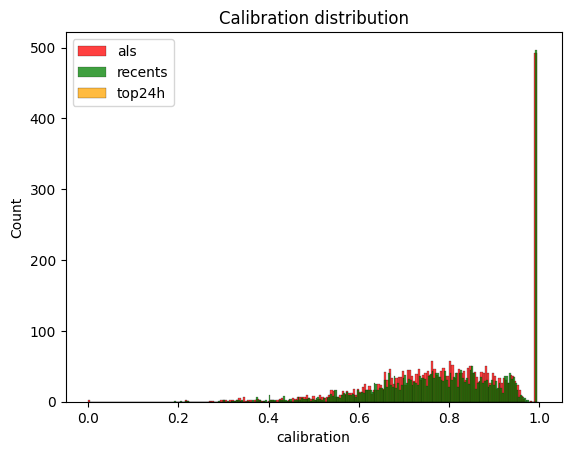

In [16]:
df = df_calibration

# Plot the histogram thanks to the histplot function
sns.histplot(data=df.loc[(df["algo"] == "als"), ["calibration"]], bins=200, x="calibration", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "recents"), ["calibration"]], bins=200, x="calibration", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "top24h"), ["calibration"]], bins=200, x="calibration", color="orange", label="naml", kde=False)
# sns.histplot(data=df.loc[(df["algo"] == "npa"), ["calibration"]], bins=200, x="calibration", color="purple", label="npa", kde=False)
# sns.histplot(data=df.loc[(df["algo"] == "pop"), ["calibration"]], bins=200, x="calibration", color="skyblue", label="pop", kde=False)

plt.title("Calibration distribution")
  
#plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
plt.legend(['als', 'recents', 'top24h'])
  
plt.show()

In [17]:
calibration_mean_std = df.groupby('algo').agg({'calibration':'mean'}).merge(
                        df.groupby('algo').agg({'calibration':'std'}), on='algo')
calibration_mean_std = calibration_mean_std.rename(columns={'calibration_x':'calibration_mean', 
                                                            'calibration_y':'calibration_std'}).reset_index()
calibration_mean_std

,algo,calibration_mean,calibration_std
0,als,0.789930,0.148645
1,recents,0.792986,0.146468
2,top,0.791163,0.145021


# Representation

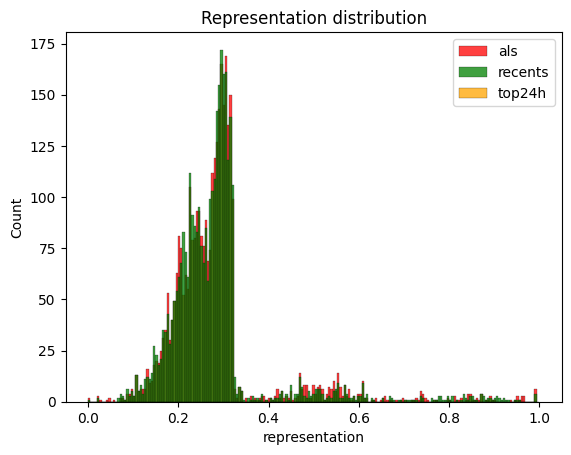

In [18]:
df = df_representation

sns.histplot(data=df.loc[(df["algo"] == "als"), ["representation"]], bins=200, x="representation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "recents"), ["representation"]], bins=200, x="representation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "top24h"), ["representation"]], bins=200, x="representation", color="orange", label="naml", kde=False)
# sns.histplot(data=df.loc[(df["algo"] == "npa"), ["representation"]], bins=200, x="representation", color="purple", label="npa", kde=False)
# sns.histplot(data=df.loc[(df["algo"] == "pop"), ["representation"]], bins=200, x="representation", color="skyblue", label="pop", kde=False)

plt.title("Representation distribution")
  
#plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
plt.legend(['als', 'recents', 'top24h'])

plt.show()

In [19]:
representation_mean_std = df.groupby('algo').agg({'representation':'mean'}).merge(
                        df.groupby('algo').agg({'representation':'std'}), on='algo')
representation_mean_std = representation_mean_std.rename(columns={'representation_x':'representation_mean', 
                                                            'representation_y':'representation_std'}).reset_index()
representation_mean_std

,algo,representation_mean,representation_std
0,als,0.285745,0.122123
1,recents,0.282557,0.119814
2,top,0.290161,0.129076


# Fragmentation

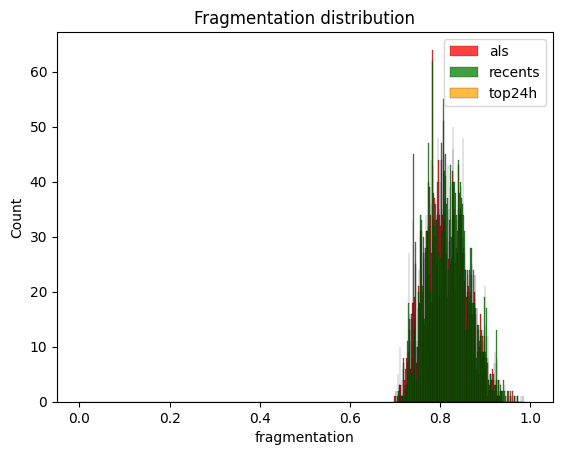

In [20]:
df = df_fragmentation
  
sns.histplot(data=df.loc[(df["algo"] == "als"), ["fragmentation"]], bins=200, x="fragmentation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "recents"), ["fragmentation"]], bins=200, x="fragmentation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "top24h"), ["fragmentation"]], bins=200, x="fragmentation", color="orange", label="naml", kde=False)
# sns.histplot(data=df.loc[(df["algo"] == "npa"), ["fragmentation"]], bins=200, x="fragmentation", color="purple", label="npa", kde=False)
# sns.histplot(data=df.loc[(df["algo"] == "pop"), ["fragmentation"]], bins=200, x="fragmentation", color="skyblue", label="pop", kde=False)

plt.title("Fragmentation distribution")
  
#plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
plt.legend(['als', 'recents', 'top24h'])
  
plt.show()

In [21]:
fragmentation_mean_std = df.groupby('algo').agg({'fragmentation':'mean'}).merge(
                        df.groupby('algo').agg({'fragmentation':'std'}), on='algo')
fragmentation_mean_std = fragmentation_mean_std.rename(columns={'fragmentation_x':'fragmentation_mean', 
                                                            'fragmentation_y':'fragmentation_std'}).reset_index()
fragmentation_mean_std

,algo,fragmentation_mean,fragmentation_std
0,als,0.81325,0.048149
1,recents,0.81508,0.047167
2,top,0.81486,0.047070
